# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

# Preprocessing

In [14]:
data = pd.read_csv('train.csv')

data = data.dropna(subset=['original'])

naive_data= data.notnull().sum()

# 성별이 NaN 처리된 데이터를 0 또는 1로 채움
# 단, 한 사람의 데이터의 경우 성별을 하나로 통일
gender = np.random.choice([0,1])
for i in data[data['1'].isnull()].iterrows():
    if i[1]['timestamp(hr)'] != 0:
        data['1'][i[0]] = gender
    else:
        data['1'][i[0]] = gender
        gender = np.random.choice([0,1])

# 나이가 NaN처리된 데이터는 나이의 평균값을 반올림하여 채움
data['2'].fillna(value= data['2'].mean().round(),inplace=True)


# 환자가 확진을 받는 시점 수 == 환자 수
patients= []
for idx, i in enumerate(data.iterrows()):
    if i[1]['timestamp(hr)'] == 0:
        patients.append(idx)

# 각 환자별로 빈값들을 Linear interpolate 밑 backfill
start =0
for  end in patients:
    data.iloc[start:end+1,:34] = data.iloc[start:end +1, :34].interpolate()
    start = end+1
start =0
for  end in patients:
    data.iloc[start:end+1,:34] = data.iloc[start:end +1, :34].interpolate(method='bfill')
    start = end+1

# 한 환자의 모든 관측정보에서 단한번도 등장하지 않았던 feature값들은 여전히 NaN
# 이 값들은 해당 데이터의 평균으로 imputation
random_weight = np.random.uniform(-2,2)
data.fillna(data.mean()+ random_weight*data.std(),inplace=True)

smote
======

Before Augmentation

0: 63085 , -1: 37555, -2: 26548, -3: 48326 (-3 : 20390, -4: 16274, -5: 11662)

After using smote

0: 63085 , -1: 60000, -2: 60000, -3: 60390 (-3 : 20390, -4: 20000, -5: 20000)

In [15]:
day_column = data['timestamp(day)'].copy()

day_column[day_column<-3] = -3
value_counts = day_column.value_counts()
print('number of label values', value_counts)

number of label values timestamp(day)
 0.0    63085
-3.0    48326
-1.0    37555
-2.0    26548
Name: count, dtype: int64


In [16]:
X = data.drop(['timestamp(day)'], axis=1).copy()
selected = data['timestamp(day)'].copy()
X_minority = X
Y_minority = selected 

smote = SMOTE(sampling_strategy={-1: 60000, -2: 60000, -4:20000,-5:20000})  
X_smote, y_smote = smote.fit_resample(X_minority, Y_minority)

X_smote.insert(34, 'timestamp(day)', y_smote)
smote_data = X_smote
day_column = smote_data['timestamp(day)']

day_column[day_column<-3] = -3
value_counts = day_column.value_counts()
print('number of label values using smote:', value_counts)

number of label values using smote: timestamp(day)
 0.0    63085
-3.0    60390
-2.0    60000
-1.0    60000
Name: count, dtype: int64


Normalize
=====


In [17]:
before_norm_smote_data = smote_data.copy()
#방법 1 : 평균 0, std 1로 normalize
scalar = StandardScaler()
features = smote_data.columns[:34]
smote_data[features] = scalar.fit_transform(smote_data[features])

# 방법 2: MIN_MAX Normalization 방식
# for column in smote_data.columns[2:34]:
#     min_val = smote_data[column].min()
#     max_val = smote_data[column].max()
#     scaled = (smote_data[column] - min_val) / (max_val - min_val)
#     smote_data[column] = scaled

# EDA


<>:30: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
<>:30: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


number of patients:  4156
mean value of label (day) w/o smote: -1.5681199220574997 median value of label (day): w/o smote -1.0
mean value of label (day) w smote: -1.4833966526337405 median value of label (day): w smote -1.0
          mean        std
0     0.586889   0.489023
1    65.488183  13.939505
2    65.542716  14.632974
3   116.739079  28.036580
4    97.801018  28.908834
5    20.708709   4.941977
6    36.978264   8.137405
7     0.032997   0.081968
8     0.302708   0.948565
9   114.210541  98.549110
10    6.919592  13.360903
11    8.754337  14.044500
12    0.082496   0.362182
13    0.908472   2.413184
14   28.872776   5.541681
15    9.666945   1.814924
16    0.120297   0.168112
17    1.220449   1.625466
18    0.657888   0.607655
19    9.096144  14.162573
20   30.945971   2.521704
21   33.430066   2.264580
22   92.395861   6.598544
23    0.433689   0.451514
24    4.043042   3.833287
25    9.788975   1.657123
26   10.179128   8.764067
27   80.893121  16.421684
28   58.035750  11.311

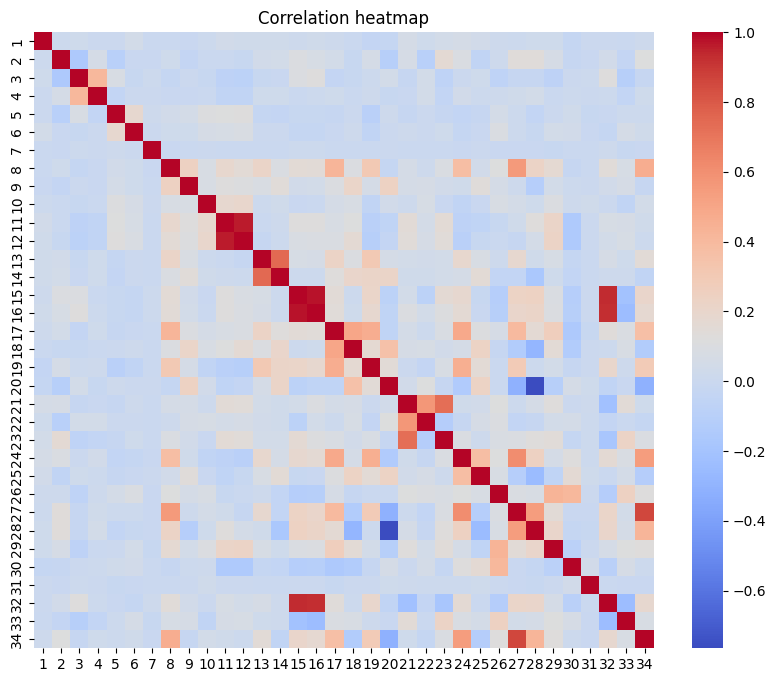

1                 166403
2                 166403
3                 146554
4                 146874
5                 147782
6                 141285
7                 143020
8                   9927
9                   9926
10                  5847
11                  9108
12                  9108
13                  9927
14                  9927
15                 11143
16                 11145
17                  8257
18                  8258
19                  9930
20                  9930
21                 11145
22                 11145
23                 11145
24                  9926
25                  9926
26                 10958
27                  9926
28                  9926
29                  9141
30                  2244
31                    41
32                 11145
33                 11141
34                 11137
timestamp(day)    175514
timestamp(hr)     175514
original          175514
dtype: int64


/tmp/ipykernel_1595512/515895073.py:30: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print("number of appropriate values: " (eigenvalue>0.83).sum())
/tmp/ipykernel_1595512/515895073.py:30: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print("number of appropriate values: " (eigenvalue>0.83).sum())
/tmp/ipykernel_1595512/515895073.py:30: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print("number of appropriate values: " (eigenvalue>0.83).sum())
/tmp/ipykernel_1595512/515895073.py:30: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print("number of appropriate values: " (eigenvalue>0.83).sum())
/tmp/ipykernel_1595512/515895073.py:30: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print("number of appropriate values: " (eigenvalue>0.83).sum())


TypeError: 'str' object is not callable

In [38]:
# 1) train dataset의 환자수
num_patients = len(patients)
print('number of patients: ', num_patients)

# 2) mean and median value of label timestamp(day)
print('mean value of label (day) w/o smote:', data['timestamp(day)'].mean(), 
    'median value of label (day): w/o smote', data['timestamp(day)'].median())

print('mean value of label (day) w smote:', before_norm_smote_data['timestamp(day)'].mean(), 
    'median value of label (day): w smote', before_norm_smote_data['timestamp(day)'].median())

# 3) dataset mean, std and heatmap of feature correlation matrix, and data sparsity
mean_std_values = pd.DataFrame(columns=['mean','std'])
mean_std_values['mean'] = before_norm_smote_data.iloc[:,:34].mean().values
mean_std_values['std'] = before_norm_smote_data.iloc[:,:34].std().values
print(mean_std_values)
correlation_matrix = before_norm_smote_data[before_norm_smote_data.columns[:34]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

print(naive_data)

# 4) answer is in report 
# 5) Calculating eigenvalues, finding appropriate number of dimension to reduce
dropped_smote_data = smote_data.drop(columns=['10','16','30','31'])
covariance = np.cov(dropped_smote_data.iloc[:,:30].T)
eigenvalue = np.linalg.eig(covariance)[0]
print("number of appropriate values: " (eigenvalue>0.83).sum())

In [35]:
np.set_printoptions(precision=2, suppress=True)


15

# Model Selection



In [ ]:
# import lightgbm as lgb
# d_train = lgb.Dataset(data.iloc[:,:34], label = data.iloc[:,34]+5)
# params={}
# params['learning_rate'] = 0.003
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'multiclass'
# params['num_class'] = 6
# clf = lgb.train(params, d_train, 100)

# train_pred = clf.predict(data.iloc[:,:34]).argmax(axis=1)-5
# train_pred[train_pred < -3] = -3

# train_label = data.iloc[:,34]
# train_label[train_label < -3] = -3
# accuracy_score(train_pred, train_label )
# f1_score(train_label, train_pred, average='macro')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7913
[LightGBM] [Info] Number of data points in the train set: 175514, number of used features: 34
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -1.289749
[LightGBM] [Info] Start training from score -1.888764
[LightGBM] [Info] Start training from score -1.541912
[LightGBM] [Info] Start training from score -1.023236


0.21690785972856635

# Model Tuning



In [ ]:
# test_data = pd.read_csv('test.csv')
# test_data = test_data.dropna(subset=['original'])


# gender = np.random.choice([0,1])
# for i in test_data[test_data['1'].isnull()].iterrows():
#     if i[1]['timestamp(hr)'] != 0:
#         test_data['1'][i[0]] = gender
#     else:
#         test_data['1'][i[0]] = gender
#         gender = np.random.choice([0,1])

# # 나이가 NaN처리된 데이터는 나이의 평균값을 반올림하여 채움
# test_data['2'].fillna(value= test_data['2'].mean().round(),inplace=True)

# # 환자가 확진을 받는 시점 수 == 환자 수
# patients= []
# for idx, i in enumerate(test_data.iterrows()):
#     if i[1]['timestamp(hr)'] == 0:
#         patients.append(idx)

# # 각 환자별로 빈값들을 Linear interpolate 밑 backfill
# start =0
# for  end in patients:
#     test_data.iloc[start:end+1,:34] = test_data.iloc[start:end +1, :34].interpolate()
#     start = end+1
# start =0
# for  end in patients:
#     test_data.iloc[start:end+1,:34] = test_data.iloc[start:end +1, :34].interpolate(method='bfill')
#     start = end+1

# test_data.fillna(data.mean(),inplace=True)

# for column in test_data.columns[2:34]:
#     min_val = test_data[column].min()
#     max_val = test_data[column].max()
#     scaled = (test_data[column] - min_val) / (max_val - min_val)
#     test_data[column] = scaled

# y_label = test_data.iloc[:,34]
# y_label[y_label < -3 ] = -3
# print(test_data)


# x_data = test_data.iloc[:,:34]
# y_pred = clf.predict(x_data) 

# y_pred = y_pred.argmax(axis=1)-5

# # y_pred = np.array(y_pred)
# y_pred[y_pred < -3] = -3 


# accuracy_score(y_label, y_pred)
# f1_score(y_label, y_pred, average='macro')


         1     2         3         4         5    6         7         8   
0      0.0  88.0  0.567164  0.413636  0.316832  0.2  0.292969  0.087719  \
122    0.0  88.0  0.567164  0.413636  0.316832  0.2  0.292969  0.035088   
123    0.0  88.0  0.567164  0.413636  0.316832  0.2  0.292969  0.035088   
125    0.0  88.0  0.563433  0.561364  0.383663  0.2  0.285216  0.035088   
127    0.0  88.0  0.559701  0.709091  0.450495  0.2  0.290643  0.035088   
...    ...   ...       ...       ...       ...  ...       ...       ...   
69118  1.0  65.0  0.544776  0.586364  0.450495  0.2  0.295295  0.016412   
69120  1.0  65.0  0.496269  0.538636  0.440594  0.2  0.291419  0.016412   
69122  1.0  65.0  0.447761  0.490909  0.430693  0.2  0.290643  0.016412   
69124  1.0  65.0  0.447761  0.490909  0.430693  0.2  0.289093  0.016412   
69126  1.0  65.0  0.447761  0.490909  0.430693  0.2  0.289868  0.016412   

              9        10  ...        28   29        30   31        32   
0      0.079365  0.256320

0.23017382859435825

# Model Evaluation / Metrics